In [1]:
from dypac.masker import LabelsMasker, MapsMasker
from nilearn.plotting import plot_roi, plot_stat_map
from nilearn import datasets

Fetch a preprocessed dataset from the ADHD sample to show how to use the DYPAC masker.

In [2]:
from nilearn import datasets
n_subjects = 1
dev_dataset = datasets.fetch_adhd(n_subjects=n_subjects)
epi_filename = dev_dataset.func[0]

/home/pbellec/env/dypac/lib/python3.8/site-packages/nilearn/datasets/func.py:250: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  phenotypic = np.genfromtxt(phenotypic, names=True, delimiter=',',


# "hard parcels": the Schaefer atlas

We fetch the Schaefer atlas using nilearn.

In [3]:
atlas = datasets.fetch_atlas_schaefer_2018()

The first thing we need to do is create a nilearn `NiftiMasker`. This masker is used to load voxel-level data, and all preprocessing is based on that step. If the fMRI data was preprocessed with fMRIprep, make sure to load confounds using one of the [nilearn strategies](https://nilearn.github.io/stable/modules/generated/nilearn.interfaces.fmriprep.load_confounds_strategy.html#nilearn.interfaces.fmriprep.load_confounds_strategy). 

In [4]:
from nilearn.maskers import NiftiMasker
masker = NiftiMasker(standardize=True, detrend=True)
masker.fit(epi_filename)

NiftiMasker(detrend=True, standardize=True)

to create the dypac masker, we simply combine the `NiftiMasker` with the Schaeffer parcels. Because these are hard (binary, non-overlapping) parcels, we use `LabelsMasker` from dypac.

In [5]:
labels_masker = LabelsMasker(masker=masker, labels_img=atlas.maps)

Now let's apply the masker to turn the fMRI dataset in a time series array, with 176 time steps x 402 regions:

In [6]:
tseries = labels_masker.transform(epi_filename)
tseries.shape

(176, 402)

it's also possible to map a vector of parcel values back into a voxel brain map:

/home/pbellec/env/dypac/lib/python3.8/site-packages/nilearn/plotting/img_plotting.py:348: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


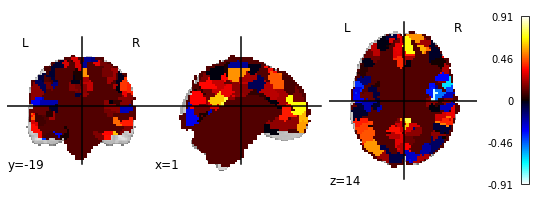

In [7]:
data_vec = tseries[0, :] # pick the first volume
data_img = labels_masker.inverse_transform(data_vec)
plot_stat_map(data_img)

The `LabelsMasker` embeds internally a vectorized representation of the Schaeffer atlas. It's possible to reconstruct these maps using the embedded `NiftiMasker`, as follows:

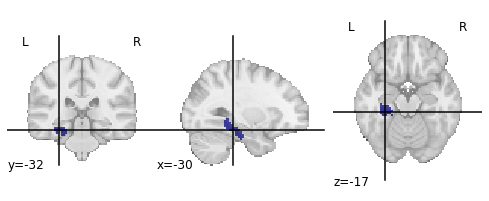

In [8]:
plot_roi(labels_masker.masker_.inverse_transform(labels_masker.components_[:,2].todense().transpose()), resampling_interpolation='nearest')

Another helper function is going to compare the preprocessed voxel based time series `tseries` with the result of a compression using parcel level data, i.e. `inverse_transform(transform(img))`. 

In [9]:
r2_map = labels_masker.score(img=[epi_filename])

Average R2: 0.08262607125083415


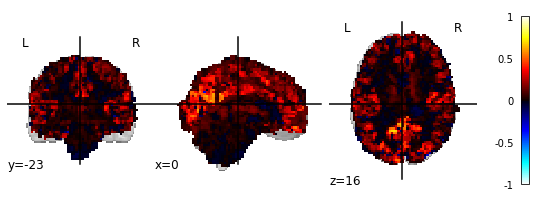

In [10]:
import numpy as np
plot_stat_map(r2_map, vmax=1)
r2_val = NiftiMasker(standardize=False, mask_img=masker.mask_img).fit_transform(r2_map)
print(f'Average R2: {np.mean(r2_val)}')

# "soft" parcels: the ICA atlas from Smith et al. (2009)

This section of the tutorial simply repeats the steps from the Schaeffer atlas, but using `MapsMasker` for weigthed parcels, rather than `LabelsMasker` which is used for hard parcels. We illustrate the behavior of that procedure with ICA maps from the Smith et al. (2009) paper. Because the steps are identical, there are no comments and just the code.

In [11]:
ica_maps = datasets.fetch_atlas_smith_2009()

In [12]:
from nilearn.maskers import NiftiMasker
masker = NiftiMasker(standardize=True, detrend=True)
masker.fit(epi_filename)

NiftiMasker(detrend=True, standardize=True)

In [13]:
maps_masker = MapsMasker(masker=masker, maps_img=ica_maps.rsn70)

In [14]:
tseries = maps_masker.transform(epi_filename)
tseries.shape

(176, 71)

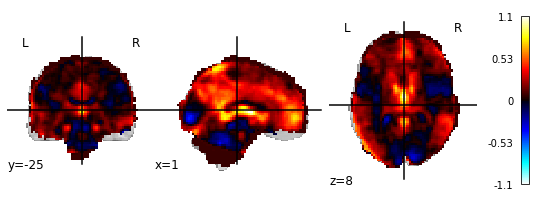

In [15]:
data_vec = tseries[0, :] # pick the first volume
data_img = maps_masker.inverse_transform(data_vec)
plot_stat_map(data_img)

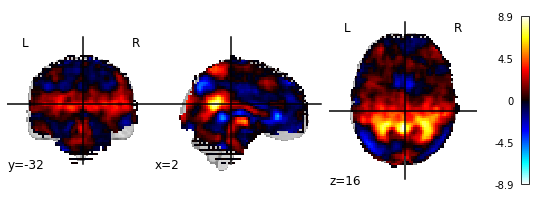

In [16]:
plot_stat_map(maps_masker.masker_.inverse_transform(maps_masker.components_[:, 5].transpose()))

In [17]:
r2_map = maps_masker.score(img=epi_filename)

Average R2: 0.06549398006910229


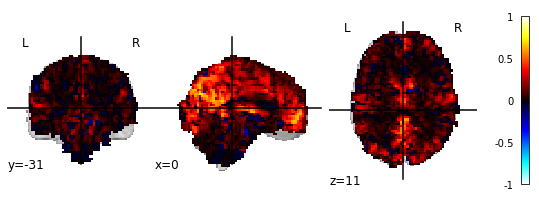

In [18]:
import numpy as np
plot_stat_map(r2_map, vmax=1)
r2_val = NiftiMasker(standardize=False, mask_img=masker.mask_img).fit_transform(r2_map)
print(f'Average R2: {np.mean(r2_val)}')

# Difumo

That section of the tutorial is identical to the one on ICA embeddings, but this time with the probabilistic parcels of difumo.

In [19]:
difumo_maps = datasets.fetch_atlas_difumo(dimension=1024)

/home/pbellec/env/dypac/lib/python3.8/site-packages/nilearn/datasets/atlas.py:129: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)


In [20]:
from nilearn.maskers import NiftiMasker
masker = NiftiMasker(standardize=True, detrend=True)
masker.fit(epi_filename)

NiftiMasker(detrend=True, standardize=True)

In [21]:
maps_masker = MapsMasker(masker=masker, maps_img=difumo_maps.maps)

In [22]:
tseries = maps_masker.transform(epi_filename)
tseries.shape

(176, 1025)

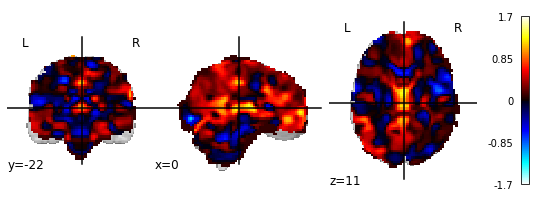

In [23]:
data_vec = tseries[0, :] # pick the first volume
data_img = maps_masker.inverse_transform(data_vec)
plot_stat_map(data_img)

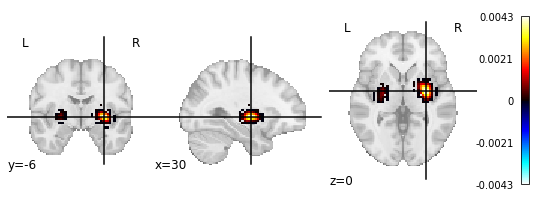

In [24]:
plot_stat_map(maps_masker.masker_.inverse_transform(maps_masker.components_[:, 5].transpose()))

In [25]:
r2_map = maps_masker.score(img=epi_filename)

Average R2: 0.16092547722834316


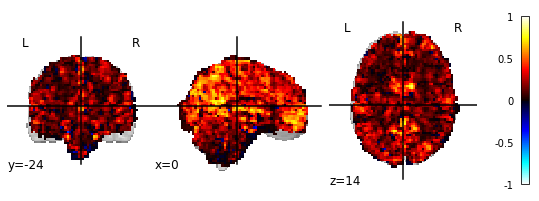

In [26]:
import numpy as np
plot_stat_map(r2_map, vmax=1)
r2_val = NiftiMasker(standardize=False, mask_img=masker.mask_img).fit_transform(r2_map)
print(f'Average R2: {np.mean(r2_val)}')